In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
from scipy.special import kl_div

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
batch_size = 2048

# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=False, num_workers=1
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, num_workers=1, generator=RNG
)

In [5]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs
# weights_pretrained = torch.load("../checkpoints/0.pt", map_location=DEVICE) #43Mbs

# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)
net.eval();

In [6]:
# Function to inject noise into the model's weights
def inject_noise(model, noise_level=0.01):
    with torch.no_grad():  
        for name, param in model.named_parameters():
            if 'weight' in name:  
                noise = torch.randn_like(param) * noise_level
                param.add_(noise)

In [8]:
def unlearning(net, retain, forget):

    unstructure_prune(net, pruning_amount=0.8, global_pruning=False, random_init=False, only_fc=True)

    epochs = 3

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()

In [9]:
X = 10  # number of times to run the unlearning algorithm
unlearn_losses = [[] for _ in range(len(forget_loader.dataset))]  # List of lists to hold losses per sample index
forget_accs = []
test_accs = []

for i in tqdm(range(X)):
    
    # Load original model
    net = resnet18(weights=None, num_classes=10)
    net.load_state_dict(weights_pretrained)
    net.to(DEVICE)

    
    inject_noise(net, noise_level=0.01)
    # Unlearn model (assuming it works in-place on the net)
    unlearning(net, retain_loader, forget_loader)
   
    # run_losses = []
    # for inputs, targets in forget_loader:
    #     inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    #     batch_losses = calculate_loss(net, inputs, targets)
    #     run_losses.extend(batch_losses)

    # for idx, loss in enumerate(run_losses):
    #     unlearn_losses[idx].append(loss)

    # Calc metrics
    forget_accs.append(accuracy(net, forget_loader))
    test_accs.append(accuracy(net, test_loader))

100%|██████████| 10/10 [07:25<00:00, 44.57s/it]


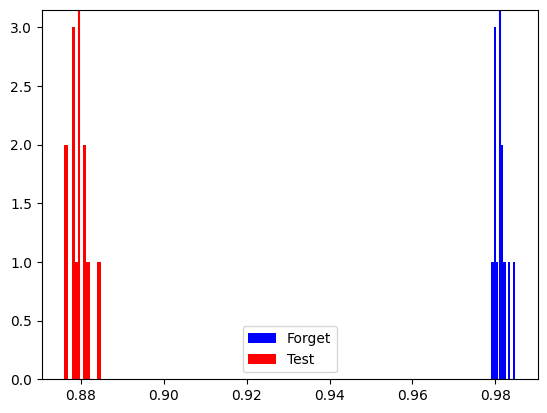

In [10]:
plt.hist(forget_accs, color='blue', label='Forget')
plt.axvline(x=np.mean(forget_accs), color='blue')
plt.hist(test_accs, color='red', label='Test')
plt.axvline(x=np.mean(test_accs), color='red')
plt.legend()
plt.show()